In [110]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


import GPE_ensemble as GPE 

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
from  torch.distributions import normal , MultivariateNormal
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion


import pickle
import emcee

%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [111]:
dat_in=pickle.load(open('parameters_original_202.pkl','rb'))

In [112]:
dat=pickle.load(open('LAT3_Case_1_20nodes.pkl','rb'))

In [113]:
dat_in

{'labels': ['tau_in', 'tau_out', 'tau_open', 'tau_close', 'conductivity'],
 'data': array([[2.8000e-01, 1.9500e+00, 2.0407e+02, 1.0509e+02, 3.0000e+00],
        [2.9000e-01, 8.5700e+00, 1.9931e+02, 1.0109e+02, 2.6200e+00],
        [2.8000e-01, 5.9600e+00, 7.3050e+01, 1.0616e+02, 3.1300e+00],
        ...,
        [4.0000e-02, 7.5100e+00, 1.2683e+02, 1.3308e+02, 1.4200e+00],
        [2.3000e-01, 1.8130e+01, 1.9381e+02, 1.4748e+02, 2.6100e+00],
        [2.1000e-01, 1.6880e+01, 1.6184e+02, 1.4655e+02, 3.4800e+00]])}

In [114]:
x_labels=dat_in.get('labels')

In [115]:
X_all=pd.DataFrame(dat_in.get('data'))
X_all.columns=x_labels

In [116]:
y_labels=list(dat.get('output').keys())

In [117]:
y_all = np.zeros((X_all.shape[0],len(y_labels)))

In [118]:
for i,k in enumerate(y_labels):
    y_all[:,[i]]=(dat.get('output').get(k))


In [119]:
y_all=pd.DataFrame(y_all)
y_all.columns=y_labels

In [120]:
y_all

,2369,42459,12964,76976,28091,82288,83487,83808,84640,57042,52134,53885,62291,63826,25112,13320,27037,7176,65141,51332
0,65.355103,40.223755,93.558960,47.438354,37.727783,51.185181,63.468262,47.071167,69.296875,12.657959,21.509155,44.467896,102.781250,78.255737,92.841309,96.487061,38.152710,67.596436,68.265259,8.939941
1,71.399170,43.874634,102.234131,51.767944,41.155273,55.858276,69.313721,51.378906,75.707275,13.723145,23.374512,48.496948,112.333130,85.483398,101.473022,105.439941,41.613403,73.834839,74.551392,9.649048
2,62.024902,38.173950,88.789673,45.020996,35.809448,48.572632,60.233765,44.675781,65.770996,12.018311,20.407959,42.194458,97.536255,74.265015,88.116699,91.567871,36.210449,64.151123,64.782959,8.491699
3,61.651123,37.863159,88.235718,44.677002,35.524902,48.198120,59.821655,44.348633,65.354248,11.848877,20.156250,41.839844,96.970947,73.772705,87.601685,91.001343,35.915527,63.736450,64.334839,8.333252
4,61.024170,37.064209,87.216797,43.836304,34.863647,47.296143,58.999268,43.614868,64.599121,11.259644,19.291626,40.872314,96.055420,72.758911,86.722656,89.996948,35.181396,62.898193,63.382446,7.722900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,17.907715,10.821777,25.422729,12.784790,10.228638,13.786865,17.229980,12.751099,18.878296,3.337769,5.625488,11.905273,28.032227,21.190918,25.292114,26.237549,10.290283,18.357910,18.470459,2.302002
198,43.475220,26.773682,62.163086,31.563354,25.126099,34.037476,42.200562,31.327393,46.084839,8.486816,14.339478,29.576294,68.288330,52.005981,61.713623,64.108887,25.401001,44.953613,45.375000,6.023682
199,33.592041,20.159424,47.847778,23.854492,19.108765,25.776855,32.342163,23.845093,35.470947,5.992310,10.276001,22.158936,52.664429,39.812500,47.574829,49.408447,19.189331,34.418579,34.670898,4.018555
200,68.337646,41.980469,97.833496,49.535767,39.386108,53.446045,66.338013,49.173340,72.465332,13.113525,22.335693,46.390259,107.494019,81.800659,97.116089,100.911621,39.817017,70.662842,71.341919,9.205444


In [121]:
X_all

,tau_in,tau_out,tau_open,tau_close,conductivity
0,0.28,1.95,204.07,105.09,3.00
1,0.29,8.57,199.31,101.09,2.62
2,0.28,5.96,73.05,106.16,3.13
3,0.25,4.01,171.15,123.42,2.91
4,0.17,3.81,79.69,100.19,1.84
...,...,...,...,...,...
197,0.03,3.63,85.83,140.71,3.66
198,0.17,20.50,139.55,112.77,4.18
199,0.04,7.51,126.83,133.08,1.42
200,0.23,18.13,193.81,147.48,2.61


# Generate Emulators

In [122]:
y_train = torch.tensor(y_all.values) #Convert data to tensor
x_train = torch.tensor(X_all.values)

### Optional: Restrict Data by parameter value

In [46]:
#y_train=y_train[x_train[:,4]<100]
#x_train=x_train[x_train[:,4]<100]

In [44]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500) # Generate emulators

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [27]:
#Parameter max and min bounds

nDim = x_train.shape[1] 
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(x_train[:,i].detach().numpy()),np.max(x_train[:,i].detach().numpy())])
    print(boundsMaxMin[i])

[0.01, 0.3]
[1.06, 29.63]
[65.25, 214.76]
[100.19, 149.6]
[0.1, 5.0]


# Visualisation and uncertainty

In [62]:
# Aim here is to plot the uncertainty in the emulators over one parameter, to do this sample from the other four
# and average the uncertainty over those random samples
n=100 #Number of samples
ref=4 #Parameter index
ki = torch.linspace(np.array(boundsMaxMin)[ref,0],np.array(boundsMaxMin)[ref,1],n) # Generate sample points for parameter of interest

Text(0.5, 0, 'conductivity')

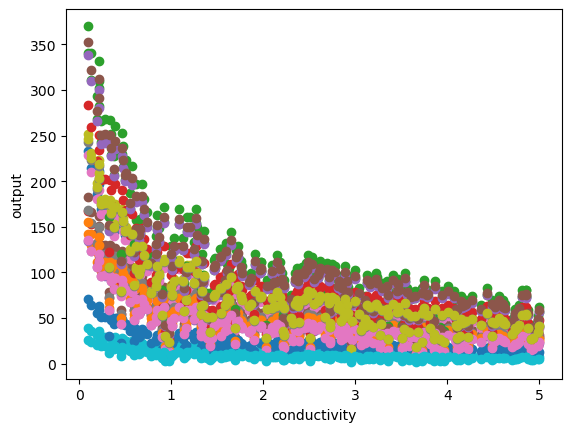

In [63]:
# Plot of output against reference parameter
plt.plot(x_train[:,ref],y_train,'o')
plt.ylabel('output')
plt.xlabel('conductivity')

In [65]:
npred =5 # Number of samples to take when during prediction step 
samp_var =np.zeros((n,y_train.shape[1])) # Sampled variance n x number of emulators
reps= 100 # number of times to sample from the other four parameters
samp_pred=np.zeros((reps,n,npred,y_train.shape[1])) # Sampled predictions reps x n x npred x number of emulators
mean_pred=np.zeros((n,y_train.shape[1]))# Mean predictions n x number of emulators
for i in range(reps):
    # Sample all 5 parameters by sampling from a transformed uniform distribution
    test =np.random.uniform(0,1,(n,x_train.shape[1]))*(np.array(boundsMaxMin)[:,1]-np.array(boundsMaxMin)[:,0])+np.array(boundsMaxMin)[:,0]
    # Set parameter of interest values to ki
    test[:,ref]=ki
    test=torch.tensor(test)
    
    samp_var+=emulator.generate_variance(test).detach().numpy().T/reps #Sampled variance averaging over repetitions
    samp_pred[i]=emulator.predict_sample(test,npred).detach().numpy() #Predictions of test, sampled npred times
    mean_pred+=emulator.predict(test).detach().numpy()/reps # Mean prediction averaging over repetitions


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:208: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  prediction=torch.stack(prediction).T


Text(0.5, 0, 'conductivity')

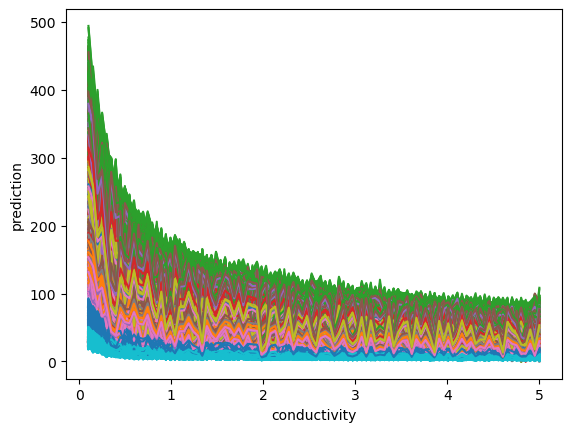

In [71]:
# Plot sampled predictions against parameter of interest
for i in range(npred):
    for j in range(reps):
        plt.plot(ki,samp_pred[j,:,i,:])
        
plt.ylabel('prediction')
plt.xlabel('conductivity')        

Text(0.5, 0, 'conductivity')

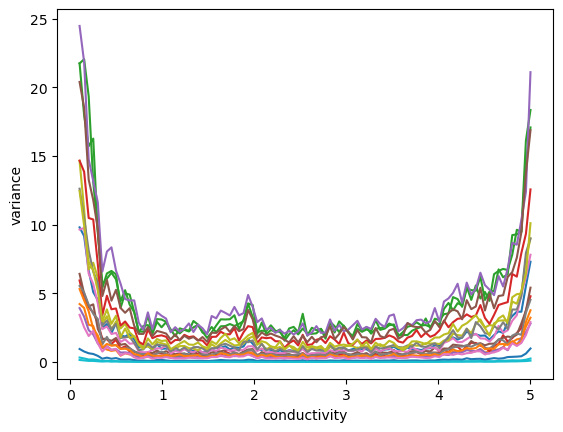

In [72]:
# Plot variance from sampled predictions (tends towards GP variance as npred -> infty)
plt.plot(ki,samp_pred.var(axis=2).mean(axis=0));
plt.ylabel('variance')
plt.xlabel('conductivity')

Text(0.5, 0, 'conductivity')

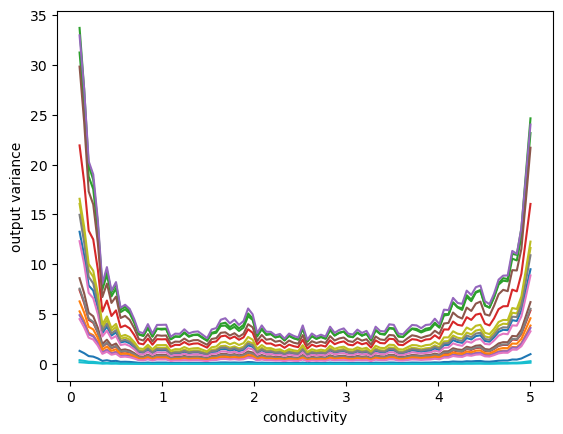

In [73]:
# Plot GP variance
plt.plot(ki,samp_var);
plt.ylabel('output variance')
plt.xlabel('conductivity')

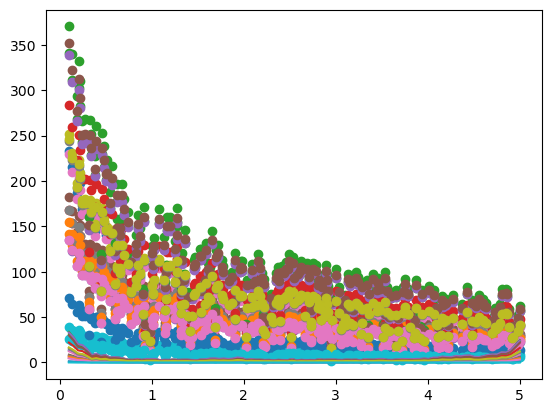

In [74]:
#Plot averaged variance alongside predictions (variance solid line, predictions dots)
plt.plot(x_train[:,ref],y_train,'o');
plt.plot(ki,samp_var);

Text(0.5, 0, 'conductivity')

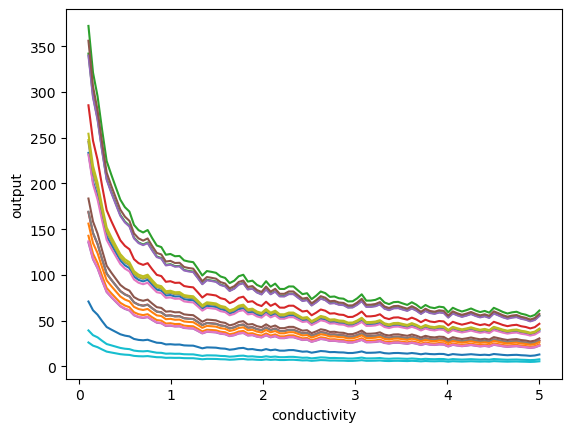

In [75]:
#Plot mean predictions

plt.plot(ki,mean_pred);
plt.ylabel('output')
plt.xlabel('conductivity')

# Global sensitivity analysis

In [76]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_76213/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [77]:
Si = []
nMod = y_all.shape[1]
nDim = x_train.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                    ST   ST_conf
tau_in        0.241608  0.035279
tau_out       0.005588  0.001412
tau_open      0.002877  0.000503
tau_close     0.001626  0.000507
conductivity  0.782072  0.062877
                    S1   S1_conf
tau_in        0.211696  0.047137
tau_out       0.003248  0.005330
tau_open      0.003131  0.004710
tau_close     0.002583  0.004563
conductivity  0.752186  0.123219
                                 S2   S2_conf
(tau_in, tau_out)          0.001708  0.057941
(tau_in, tau_open)         0.002038  0.057296
(tau_in, tau_close)        0.001505  0.058280
(tau_in, conductivity)     0.025811  0.111994
(tau_out, tau_open)       -0.001104  0.008410
(tau_out, tau_close)      -0.001233  0.008431
(tau_out, conductivity)    0.001664  0.016748
(tau_open, tau_close)     -0.000272  0.006192
(tau_open, conductivity)   0.000284  0.009219
(tau_close, conductivity) -0.001884  0.011381
                    ST   ST_conf
tau_in        0.243223  0.035742
tau_out       0.006096  0.001586

                    ST   ST_conf
tau_in        0.239781  0.032936
tau_out       0.006107  0.001674
tau_open      0.002985  0.000472
tau_close     0.001916  0.000698
conductivity  0.780282  0.063844
                    S1   S1_conf
tau_in        0.213725  0.050731
tau_out       0.003651  0.006750
tau_open      0.003304  0.005038
tau_close     0.002746  0.005867
conductivity  0.754582  0.121574
                                 S2   S2_conf
(tau_in, tau_out)          0.001619  0.057513
(tau_in, tau_open)         0.002053  0.057139
(tau_in, tau_close)        0.001497  0.057745
(tau_in, conductivity)     0.021529  0.096634
(tau_out, tau_open)       -0.001224  0.010423
(tau_out, tau_close)      -0.001373  0.010486
(tau_out, conductivity)    0.001817  0.024023
(tau_open, tau_close)     -0.000370  0.006818
(tau_open, conductivity)   0.000323  0.008715
(tau_close, conductivity) -0.001896  0.012580
                    ST   ST_conf
tau_in        0.235460  0.028625
tau_out       0.006019  0.001617

In [78]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


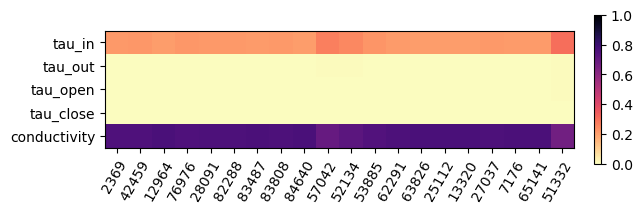

In [79]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

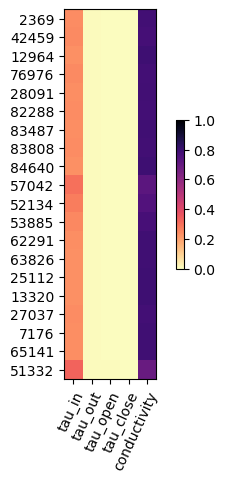

In [80]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=65, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

# MCMC

In [81]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2 # establish centre of data

In [82]:
boundsMaxMin=np.array(boundsMaxMin) # convert bounds to array

In [83]:
#Uniform prior

def log_prior_uni(theta):
        
    if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        return 0.0
    return -np.inf

In [84]:
#Normal prior

def log_prior_norm(theta,dist):
    theta=torch.tensor(theta)
    val = dist.log_prob(theta)
    return val

In [85]:
# Compute emulator log likelihood

def log_likelihood(x,emulator,y_val,obs_error):
    with gpytorch.settings.fast_pred_var(): #This line makes it fast!
        x=torch.tensor(x)[None]
        ll =torch.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],obs_error)))
        ll=ll.detach().numpy()
    return ll

In [86]:
#Compute log probabiliy (ll+prior)

def log_prob(theta, emulator,y_val,obs_error,prior='uni',prior_dist=None):
    
    if prior=='uni':
        lp = log_prior_uni(theta)
        if not np.isfinite(lp):
            return -np.inf
    if prior=='norm':
        lp = log_prior_norm(theta,prior_dist)
    return lp + log_likelihood(theta,emulator, y_val,obs_error)

In [87]:
#Split data into train and test

# X=torch.tensor(x_train)
# y=torch.tensor(y_train)
# x_train, x_test, y_train, y_test = train_test_split(
#     X,
#     y,
#     test_size=0.1
# )

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_76213/2173809985.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X=torch.tensor(x_train)
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_76213/2173809985.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(y_train)


In [146]:
cal_index = 52
x_test = x_train[52]
y_test = y_train[52]
x_train2 = torch.cat([x_train[0:cal_index], x_train[cal_index+1:]])
y_train2 = torch.cat([y_train[0:cal_index], y_train[cal_index+1:]])

In [129]:
x_test

tensor([[  0.2400,   3.5600,  71.0500, 100.3600,   3.7300]],
       dtype=torch.float64)

In [130]:
#train emulators on split data

emulator = GPE.ensemble(x_train2,y_train2,mean_func="linear",training_iter=1000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [134]:
y_test

tensor([[ 43.6920,  26.5356,  62.3599,  31.3726,  24.9756,  33.8390,  42.2092,
          31.2211,  46.2173,   8.1100,  13.8337,  29.2500,  68.6992,  52.0255,
          62.0176,  64.3461,  25.1943,  45.0005,  45.3293,   5.5840],
        [103.3219,  62.3093, 147.6189,  73.7988,  58.7218,  79.6831,  99.7202,
          73.5350, 109.2872,  18.5063,  31.9584,  68.6575, 162.7303, 122.9568,
         146.8092, 152.3839,  59.1702, 106.2611, 107.0535,  12.4312],
        [ 26.8143,  16.3503,  38.2184,  19.3064,  15.3859,  20.8088,  25.9076,
          19.2032,  28.3540,   5.0969,   8.6108,  18.0217,  42.0909,  31.9148,
          38.0117,  39.4261,  15.5256,  27.6282,  27.8217,   3.5657],
        [ 94.1859,  56.7299, 134.4823,  67.1938,  53.5001,  72.5564,  90.8484,
          66.9800,  99.5792,  16.8311,  29.0460,  62.4911, 148.2733, 111.9874,
         133.7511, 138.8320,  53.8838,  96.7958,  97.5024,  11.2856],
        [165.8595,  99.3452, 236.6934, 117.7678,  93.8843, 127.2520, 159.7329,
         

In [147]:
 emulator.R2(x_test,y_test) #Check emulator predictive accuracy

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 5 but got size 1 for tensor number 1 in the list.

In [148]:
emulator.MSE(x_test,y_test) #Check emulator predictive accuracy

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 5 but got size 1 for tensor number 1 in the list.

In [149]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2 # centre of bounds
ndim = x_train.shape[1] # number of parameters 
nwalkers = 10 # number of walkers
# initialising walkers within initial ranges 
p0 = np.random.uniform(0,1,(nwalkers,ndim))*(np.array(boundsMaxMin)[:,1]-np.array(boundsMaxMin)[:,0])+np.array(boundsMaxMin)[:,0]
y_val=y_test # set calibration value
obs_error=((y_val*0.05))**2 # set obs error at 5% of calibration values

In [150]:
((boundsMaxMin[:,1]-boundsMaxMin[:,0]))

array([  0.29,  28.57, 149.51,  49.41,   4.9 ])

In [151]:
prior_mean=torch.tensor([0.15,15.,140.,125.,2.5]) # set prior mean
prior_cov=torch.eye(5) # set prior covariance as same for all parameters
#prior_cov=torch.tensor(((boundsMaxMin[:,1]-boundsMaxMin[:,0]))**2)*torch.eye(5) # set prior covariance based on bounds
obs_error=0.1*torch.ones(20) # set obs error at fixed value for each emulator
dist = MultivariateNormal(loc=prior_mean, covariance_matrix=prior_cov) #Prior distribution

In [165]:
# set up MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val,obs_error,'uni',dist])

In [166]:
# run MCMC
sampler.run_mcmc(p0, 20000,progress=True)

100%|█████████████████████████████████████| 20000/20000 [32:28<00:00, 10.27it/s]


State([[2.44618167e-01 8.48116000e+00 1.59325655e+02 1.21767814e+02
  4.03293163e+00]
 [1.88065287e-01 1.68566935e+01 1.86860321e+02 1.29003179e+02
  3.38965591e+00]
 [1.88936324e-01 9.70464774e+00 1.25838110e+02 1.28253461e+02
  2.90306965e+00]
 [2.10782564e-01 1.81126741e+01 1.57804561e+02 1.07077994e+02
  3.52548953e+00]
 [2.40638206e-01 1.62920322e+01 1.29124818e+02 1.10870548e+02
  3.88827537e+00]
 [2.02463073e-01 9.41723784e+00 1.65761175e+02 1.28499721e+02
  3.35815850e+00]
 [2.36145374e-01 1.18092362e+01 1.46184096e+02 1.25647818e+02
  3.85509082e+00]
 [2.08146163e-01 1.09629608e+01 1.35815853e+02 1.33021320e+02
  3.33420500e+00]
 [9.15592189e-02 2.96260790e+01 1.00120209e+02 1.33352757e+02
  4.99696681e+00]
 [2.09867594e-01 1.64375142e+01 1.64733307e+02 1.21569448e+02
  3.57446740e+00]], log_prob=[  -6.20124626   -6.19383955   -7.65225315   -6.12544441   -4.77241421
   -5.08201361   -4.97166252   -5.9277277  -273.35839844   -4.27814579], blobs=None, random_state=('MT19937', ar

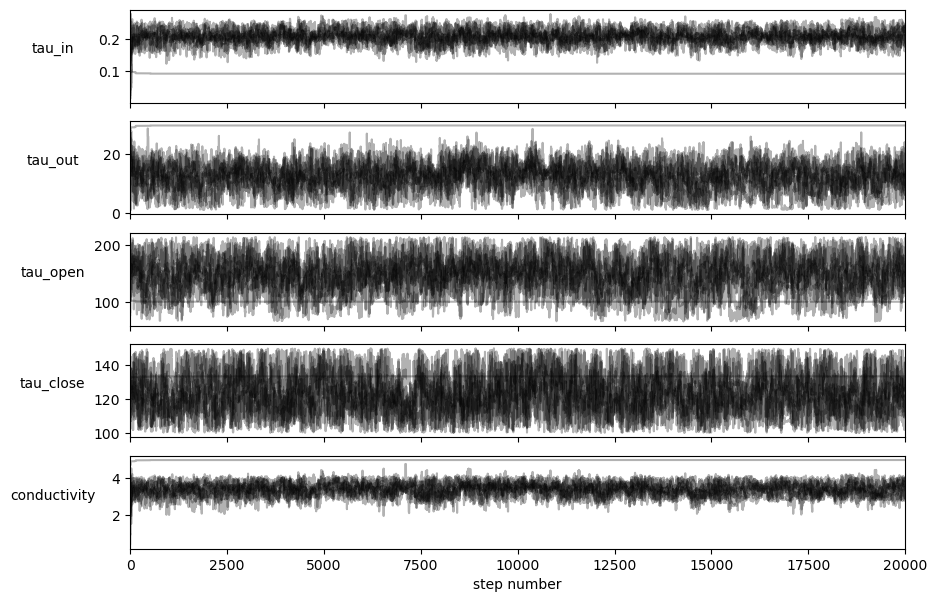

In [168]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [169]:
#Flatten samples

flat_samples = sampler.get_chain(discard=2000, thin=10, flat=True)
print(flat_samples.shape)


(18000, 5)


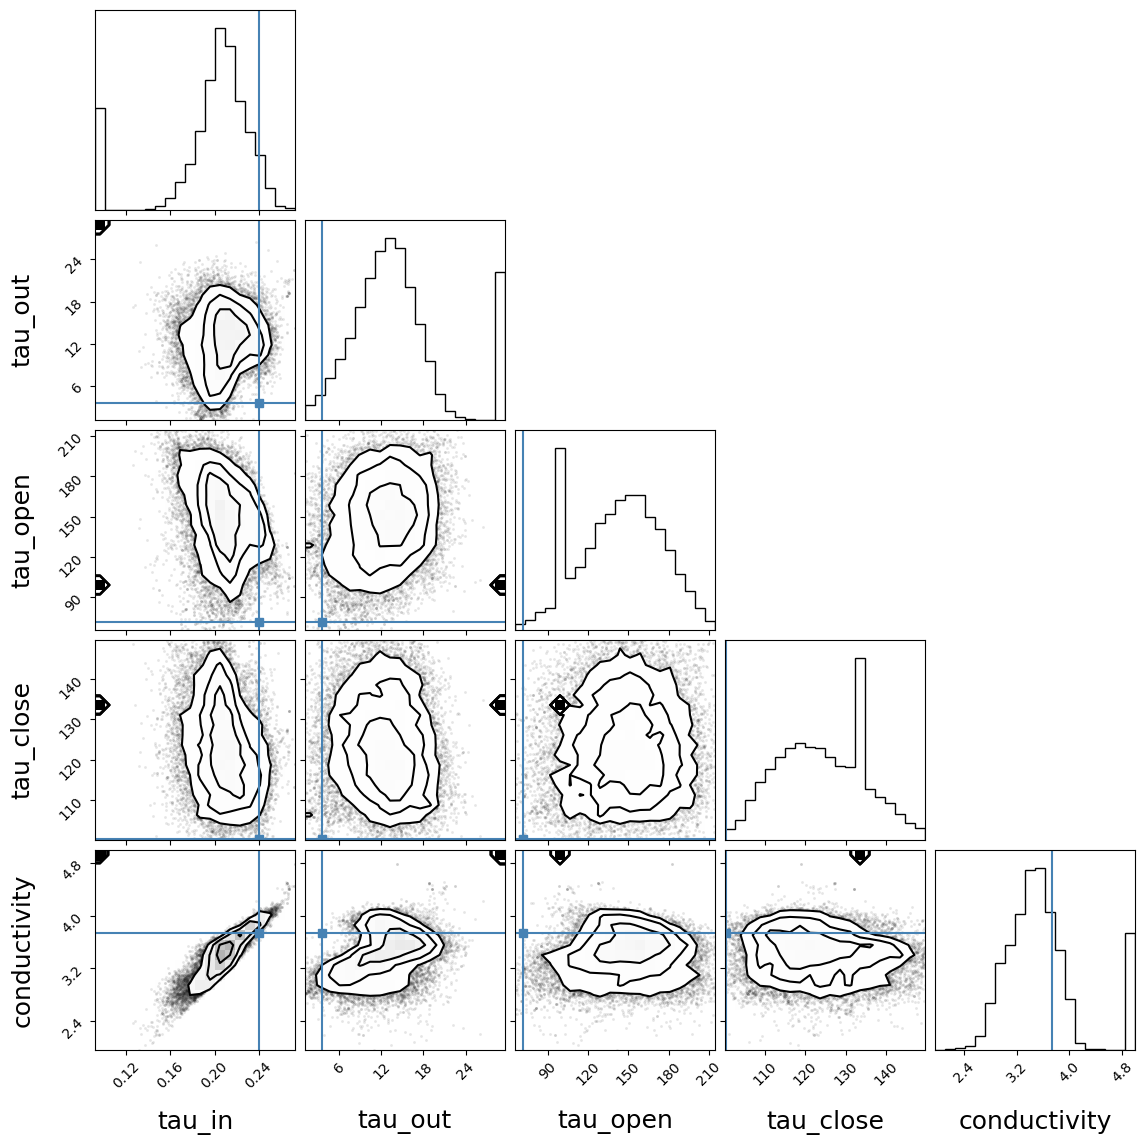

In [170]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels, label_kwargs=dict(fontsize=18),truths=x_test
);

(array([ 1800.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 16200.]),
 array([17.35245895, 18.90347481, 20.45448875, 22.00550461, 23.55651855,
        25.10753441, 26.65855026, 28.20956421, 29.76058006, 31.31159401,
        32.86260986]),
 <BarContainer object of 10 artists>)

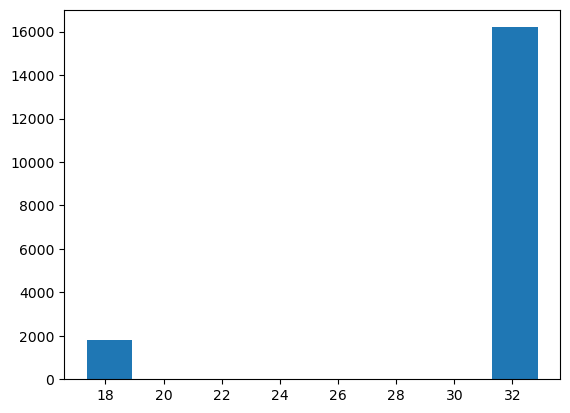

In [171]:
plt.hist(emulator.predict(torch.tensor(flat_samples)).detach().numpy()[:,1])

In [172]:
y_val

tensor([52.7112, 32.4807, 75.4229, 38.2909, 30.4720, 41.3046, 51.1942, 37.9940,
        55.8894, 10.2877, 17.4146, 35.8978, 82.8418, 63.1018, 74.8484, 77.7789,
        30.8137, 54.5199, 55.0565,  7.2998], dtype=torch.float64)

In [173]:
emulator.predict(torch.tensor(flat_samples)).mean(axis=0)

tensor([50.3160, 30.9368, 71.9572, 36.4638, 29.0226, 39.3423, 48.8313, 36.2208,
        53.3354,  9.7344, 16.5006, 34.1498, 79.0534, 60.1565, 71.4065, 74.1918,
        29.3464, 51.9928, 52.4746,  6.8709], grad_fn=<MeanBackward1>)

In [174]:
emulator.predict(torch.tensor(flat_samples)).std(axis=0)

tensor([ 7.3457,  4.5188, 10.5639,  5.3990,  4.2588,  5.8028,  7.1797,  5.3086,
         7.8037,  1.4115,  2.4288,  5.0706, 11.6698,  8.8847, 10.6412, 10.9961,
         4.3034,  7.6632,  7.7396,  0.9970], grad_fn=<StdBackward0>)

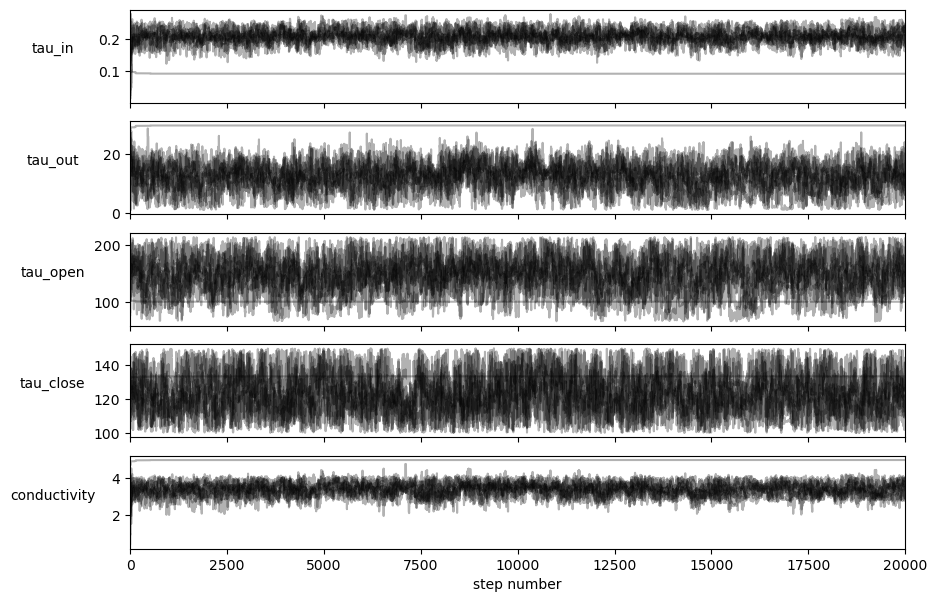

In [175]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

# VI (not currently working very well)

In [176]:
dtype = torch.float32
device = torch.device("cpu")

In [177]:
def ELBO(m,s2,x,emulator,y,prior_mean,prior_cov,obs_error):
    
    L=torch.zeros((x.shape[0],x.shape[0]))
    #L=L.diagonal_scatter(s2)
    L[np.tril_indices(x.shape[0])]=torch.exp(s2)
    #L[1,0]=param[6]
   # L[2,0]=param[7]
   # L[2,1] =param[8]
    covar = L.matmul(L.T)
    z=L.matmul(x)+m
    
    z=z.T 
    with gpytorch.settings.fast_pred_var(): #This line makes it fast!
        mc_int = (emulator.ensemble_log_likelihood_obs_error(z,y,obs_error)+x_prior(z,prior_mean,prior_cov)[None]).mean()

    lb = mc_int - q_prior(covar)
    
    #print(mc_int/x.shape[1])
    #print(-q_prior(covar))
    #print(np.mean(z,axis=0))
    #print(-lb)
    return -lb
    

def ELBO_fun(m,s2,x,function,y,prior_mean,prior_cov,obs_error):
    
    L=torch.zeros((x.shape[0],x.shape[0]))
    L[np.tril_indices(x.shape[0])]=torch.exp(s2)
    
    #L[1,0]=param[6]
   # L[2,0]=param[7]
   # L[2,1] =param[8]
    covar = L.matmul(L.T)
    z=L.matmul(x)+m
   
    z=z.T
    
    lb = (f_likelihood(z.T,y,function,obs_error)+x_prior(z[None],prior_mean,prior_cov)).mean()- q_prior(covar)
        #mc_int +=-np.log(np.sum(((emulator.predict(z.iloc[[i]]).detach().numpy()-y.values)**2)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov))
        #mc_int += (np.sum(np.log(emulator.ensemble_likelihood(z.iloc[[i]],y)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov)))
    
    #print(mc_int/x.shape[1])
    #print(-q_prior(covar))
    #print(np.mean(z,axis=0))
    #print(-lb)
    return -lb

def x_prior(x,mean,cov):

    #var = scipy.stats.multivariate_normal(mean=mean, cov=cov)
    #val1 = var.pdf(x)
    dist = MultivariateNormal(loc=mean, covariance_matrix=cov)
    val = dist.log_prob(x)
    return val

def q_prior(covar):
    qp = -(covar.shape[0]/2)*(1+torch.log(torch.tensor(2*torch.pi)))-0.5*torch.log(torch.linalg.det(covar))
    return qp

def f_likelihood(x,y,f,sigma2):
    #x,f=emulator.normalise_test_data(x,f(x))
    #x,y=emulator.normalise_test_data(x,y)
    
    likelihood_manual=-0.5*((f(x) - y)**2)/(sigma2)- 0.5*torch.log(torch.tensor(2*np.pi))-0.5*torch.log(sigma2)
    return likelihood_manual

def f_likelihood2(x,y,f,sigma2):
    
    likelihood_manual=-0.5*((f(x) - y)**2)/(sigma2)- 0.5*np.log(2*np.pi)-0.5*np.log(sigma2)
    return likelihood_manual

In [ ]:
elb = []
ms=[]
s2s=[]

for i in range(5):

    ### initialize the variational parameters
    noi=torch.distributions.MultivariateNormal(torch.zeros(5), torch.eye(5)).sample()  
    m = torch.tensor(centre,requires_grad=True)[:,None]+noi[:,None]
    m.retain_grad()
    s2 = torch.full((len(np.tril_indices(x_train.shape[1])[0]),),0.01,dtype=dtype , requires_grad=True, device=device)


    # Samples fixed here - but try adding them into the loop
    nsamples = 10000
    #Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)

    learning_rate_m = torch.tensor([1e-2,1e-2,1,1,1])[:,None]
    learning_rate_s = 1e-2*torch.ones(1,len(np.tril_indices(x_train.shape[1])[0])).squeeze()
    for t in range(20000):
        Z = torch.randn((5,nsamples), dtype=dtype, requires_grad=False, device=device)
        #negELBO = -Eloglike(m,log_s2)+KL(log_s2)

        negELBO = ELBO(m,s2,Z,emulator,y_val[None],prior_mean,prior_cov,obs_error)
        if t % 100 == 99:
            print(t,negELBO.item(),'m=',m)
            #print(t, negELBO.item(), 'm=', m.item(), 's2=', s2.pow(2).item())
          #  print(m)
          #  print(s2)
          #   print(negELBO)
        # Use autograd to compute the backward pass. This call will compute the
        # gradient of loss with respect to all Tensors with requires_grad=True.
        # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
        # the gradient of the loss with respect to a, b, c, d respectively.
        negELBO.backward()

        # Manually update weights using gradient descent. Wrap in torch.no_grad()
        # because weights have requires_grad=True, but we don't need to track this
        # in autograd.
        with torch.no_grad():

            m -= learning_rate_m * m.grad
            s2 -= learning_rate_s * s2.grad

            # Manually zero the gradients after updating weights
            m.grad = None
            s2.grad = None
    elb.append(negELBO)
    ms.append(m)
    s2s.append(s2)
    #print(f'Result: p(x|y) = N({m.item()}, {torch.pow(s2,2).item()}) ')


/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


99 18.545551300048828 m= tensor([[-1.0056e+00],
        [ 1.4798e+01],
        [ 1.4000e+02],
        [ 1.2500e+02],
        [-7.6771e-02]], dtype=torch.float64, grad_fn=<AddBackward0>)
199 18.190793991088867 m= tensor([[ -0.9428],
        [ 14.9371],
        [139.9992],
        [124.9895],
        [  0.5567]], dtype=torch.float64, grad_fn=<AddBackward0>)
299 16.362136840820312 m= tensor([[ -0.9795],
        [ 14.9899],
        [140.0117],
        [125.0097],
        [ -0.7407]], dtype=torch.float64, grad_fn=<AddBackward0>)
399 16.194854736328125 m= tensor([[ -0.9484],
        [ 15.0078],
        [140.0018],
        [125.0128],
        [ -0.3016]], dtype=torch.float64, grad_fn=<AddBackward0>)
499 16.529699325561523 m= tensor([[ -0.9929],
        [ 15.0153],
        [139.9997],
        [125.0040],
        [ -1.1676]], dtype=torch.float64, grad_fn=<AddBackward0>)
599 16.601551055908203 m= tensor([[ -1.0299],
        [ 15.0188],
        [139.9977],
        [125.0077],
        [ -1.1535]],

4899 17.036184310913086 m= tensor([[ -1.0065],
        [ 15.0195],
        [139.9986],
        [125.0042],
        [ -1.5709]], dtype=torch.float64, grad_fn=<AddBackward0>)
4999 15.641876220703125 m= tensor([[ -1.0265],
        [ 15.0200],
        [139.9971],
        [125.0017],
        [ -0.4264]], dtype=torch.float64, grad_fn=<AddBackward0>)
5099 15.699400901794434 m= tensor([[ -0.9877],
        [ 15.0201],
        [139.9939],
        [124.9792],
        [ -0.9687]], dtype=torch.float64, grad_fn=<AddBackward0>)
5199 15.69998550415039 m= tensor([[ -1.0482],
        [ 15.0190],
        [139.9756],
        [125.0112],
        [ -0.5166]], dtype=torch.float64, grad_fn=<AddBackward0>)
5299 15.699291229248047 m= tensor([[ -1.0039],
        [ 15.0195],
        [140.0135],
        [124.9801],
        [ -0.9800]], dtype=torch.float64, grad_fn=<AddBackward0>)
5399 18.0771427154541 m= tensor([[ -1.0104],
        [ 15.0205],
        [140.0131],
        [124.9991],
        [ -1.8893]], dtype=torc

9699 18.406272888183594 m= tensor([[ -0.9155],
        [ 15.0195],
        [139.9760],
        [125.0133],
        [  0.9357]], dtype=torch.float64, grad_fn=<AddBackward0>)
9799 16.556564331054688 m= tensor([[ -1.0273],
        [ 15.0189],
        [139.9910],
        [125.0025],
        [  0.3291]], dtype=torch.float64, grad_fn=<AddBackward0>)
9899 15.592493057250977 m= tensor([[ -1.0256],
        [ 15.0199],
        [140.0057],
        [124.9957],
        [ -0.4771]], dtype=torch.float64, grad_fn=<AddBackward0>)
9999 15.622940063476562 m= tensor([[-9.7150e-01],
        [ 1.5020e+01],
        [ 1.3998e+02],
        [ 1.2501e+02],
        [-1.2522e-01]], dtype=torch.float64, grad_fn=<AddBackward0>)
10099 15.768228530883789 m= tensor([[ -1.0205],
        [ 15.0194],
        [139.9999],
        [125.0164],
        [ -0.2046]], dtype=torch.float64, grad_fn=<AddBackward0>)
10199 16.46573257446289 m= tensor([[ -1.0096],
        [ 15.0189],
        [140.0028],
        [124.9971],
        [ -1

14399 17.618799209594727 m= tensor([[ -1.0392],
        [ 15.0196],
        [140.0157],
        [125.0137],
        [  0.8786]], dtype=torch.float64, grad_fn=<AddBackward0>)
14499 17.877490997314453 m= tensor([[ -0.9108],
        [ 15.0194],
        [139.9968],
        [124.9946],
        [  0.7226]], dtype=torch.float64, grad_fn=<AddBackward0>)
14599 19.302593231201172 m= tensor([[ -0.9511],
        [ 15.0187],
        [140.0120],
        [124.9927],
        [  2.0053]], dtype=torch.float64, grad_fn=<AddBackward0>)
14699 16.396198272705078 m= tensor([[ -1.0416],
        [ 15.0197],
        [140.0131],
        [125.0010],
        [  0.2648]], dtype=torch.float64, grad_fn=<AddBackward0>)
14799 18.722013473510742 m= tensor([[ -0.9544],
        [ 15.0193],
        [140.0127],
        [124.9970],
        [  1.4354]], dtype=torch.float64, grad_fn=<AddBackward0>)
14899 18.628768920898438 m= tensor([[ -0.9602],
        [ 15.0197],
        [139.9933],
        [124.9968],
        [  1.3989]], d

19099 17.333332061767578 m= tensor([[ -0.9851],
        [ 15.0196],
        [139.9924],
        [125.0041],
        [  0.7097]], dtype=torch.float64, grad_fn=<AddBackward0>)
19199 17.228670120239258 m= tensor([[ -0.9398],
        [ 15.0191],
        [139.9894],
        [125.0381],
        [ -1.7663]], dtype=torch.float64, grad_fn=<AddBackward0>)
19299 17.71685791015625 m= tensor([[ -0.9887],
        [ 15.0193],
        [140.0077],
        [125.0016],
        [ -1.8274]], dtype=torch.float64, grad_fn=<AddBackward0>)
19399 17.323474884033203 m= tensor([[ -1.0274],
        [ 15.0206],
        [140.0122],
        [124.9833],
        [  0.7579]], dtype=torch.float64, grad_fn=<AddBackward0>)
19499 17.11553192138672 m= tensor([[ -1.0173],
        [ 15.0206],
        [139.9901],
        [125.0006],
        [ -1.5789]], dtype=torch.float64, grad_fn=<AddBackward0>)
19599 15.2726411819458 m= tensor([[ -0.9416],
        [ 15.0196],
        [139.9896],
        [125.0098],
        [ -0.3069]], dtype

In [ ]:
x_test